In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
        print(dirname)

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/test
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

# Exploratory Data Analysis and Pre-Processing

## dicom format : 

A DICOM file is an image saved in the Digital Imaging and Communications in Medicine (DICOM) format. It contains an image from a medical scan, such as an ultrasound or MRI. **

In [3]:
train = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv"))
test = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv"))

In [4]:
train.shape, test.shape

((33126, 8), (10982, 5))

So, there are around 33k training images and about 10k testing images

In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


Every patient has an ID, however it might be that one patient may have multiple wound records. Let's fish that out.

In [8]:
len(train["patient_id"].unique())

2056

In [9]:
train["target"].value_counts()

0    32542
1      584
Name: target, dtype: int64

### Distribution Observation

Malignant VS Benign cases - OVERALL

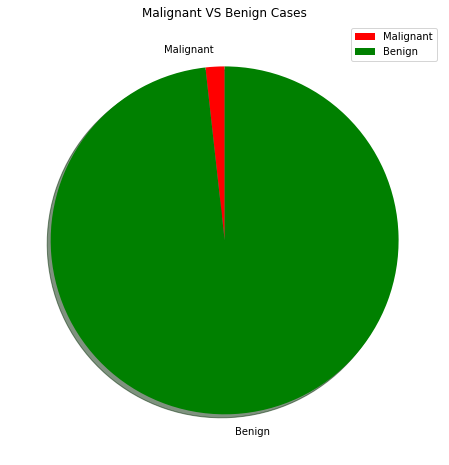

In [10]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0])

labels = ["Malignant", "Benign"] 
size = [malignant, benign]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])
plt.title("Malignant VS Benign Cases")
plt.legend()

Malignant male cases VS female cases

Malignant Male Cases =  364
Malignant Female Cases =  220


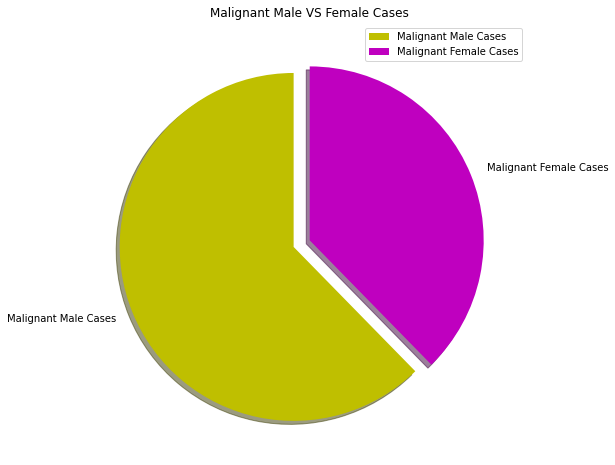

In [11]:
malignant  = train[train["target"] == 1]

malignant_males = len(malignant[malignant["sex"] == "male"])
malignant_females  = len(malignant[malignant["sex"] == "female"])

labels = ["Malignant Male Cases", "Malignant Female Cases"] 
size = [malignant_males, malignant_females]
explode = [0.1, 0.0]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["y", "m"])
plt.title("Malignant Male VS Female Cases")
plt.legend()
print("Malignant Male Cases = ", malignant_males)
print("Malignant Female Cases = ", malignant_females)

Benign male cases vs female cases

Benign Male Cases =  16716
Benign Female Cases =  15761


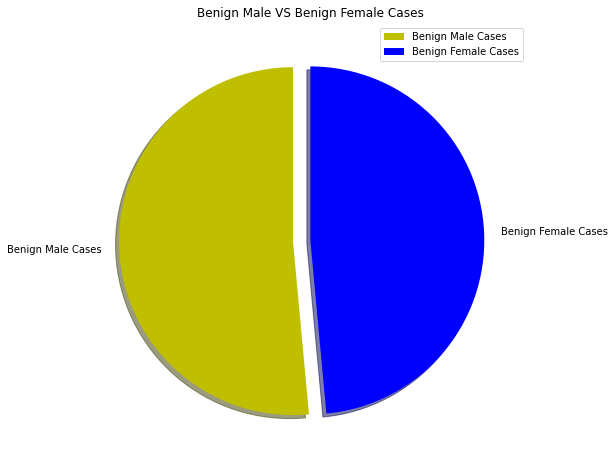

In [12]:
benign  = train[train["target"] == 0]

benign_males = len(benign[benign["sex"] == "male"])
benign_females  = len(benign[benign["sex"] == "female"]) 

labels = ["Benign Male Cases", "Benign Female Cases"] 
size = [benign_males, benign_females]
explode = [0.1, 0.0]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["y", "b"])
plt.title("Benign Male VS Benign Female Cases")
plt.legend()
print("Benign Male Cases = ", benign_males)
print("Benign Female Cases = ", benign_females)

In [13]:
print(train["anatom_site_general_challenge"].unique())
print(train["anatom_site_general_challenge"].value_counts())

['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64


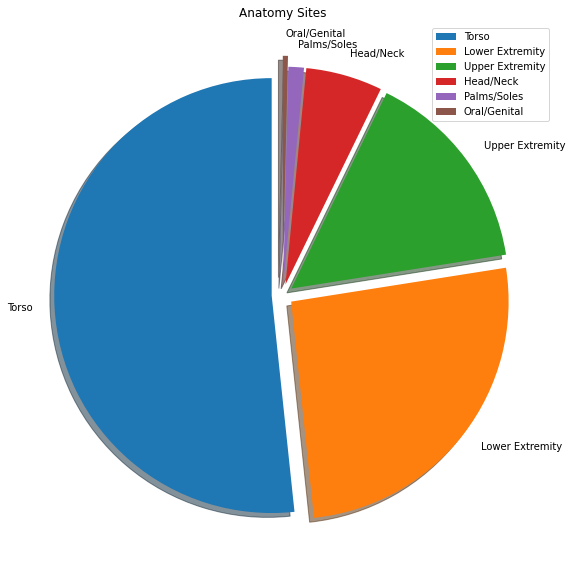

In [14]:
torso = len(train[train["anatom_site_general_challenge"] == "torso"])
lower_extremity = len(train[train["anatom_site_general_challenge"] == "lower extremity"])
upper_extremity = len(train[train["anatom_site_general_challenge"] == "upper extremity"])
head_neck = len(train[train["anatom_site_general_challenge"] == "head/neck"])
palms_soles = len(train[train["anatom_site_general_challenge"] == "palms/soles"])
oral_genital = len(train[train["anatom_site_general_challenge"] == "oral/genital"])

labels = ["Torso", "Lower Extremity", "Upper Extremity", "Head/Neck", "Palms/Soles", "Oral/Genital"] 
size = [torso,lower_extremity, upper_extremity, head_neck, palms_soles, oral_genital]
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.1]
plt.figure(figsize = (12, 10))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90)
plt.title("Anatomy Sites")
plt.legend()

Text(0.5, 1.0, 'Probabilistic Age Distribution')

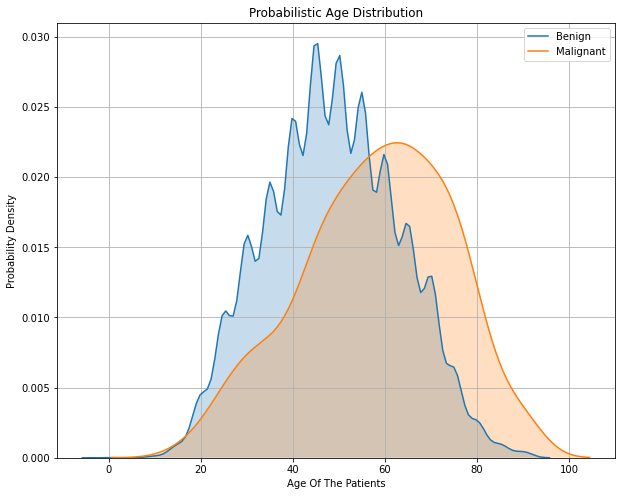

In [15]:
ages_benign = train.loc[train["target"] == 0, "age_approx"]
ages_malignant = train.loc[train["target"] == 1 , "age_approx"]

plt.figure(figsize = (10, 8))
sns.kdeplot(ages_benign, label = "Benign", shade = True, legend = True, cbar = True)
sns.kdeplot(ages_malignant, label = "Malignant", shade = True, legend = True, cbar = True)
plt.grid(True)
plt.xlabel("Age Of The Patients")
plt.ylabel("Probability Density")
plt.grid(which = "minor", axis = "both")
plt.title("Probabilistic Age Distribution")

In [16]:
image_names = train["image_name"].values
image_names = image_names + ".jpg"
image_names

array(['ISIC_2637011.jpg', 'ISIC_0015719.jpg', 'ISIC_0052212.jpg', ...,
       'ISIC_9999515.jpg', 'ISIC_9999666.jpg', 'ISIC_9999806.jpg'],
      dtype=object)

We generate 4 random samples from the training data set. These 4 samples are taken from the aforementioned array of names.

In [17]:
random_images = [np.random.choice(image_names) for i in range(4)]
random_images 

['ISIC_4856654.jpg',
 'ISIC_3146092.jpg',
 'ISIC_1323427.jpg',
 'ISIC_3820602.jpg']

Earlier we extracted paths of all directories. So, we will access these images from there.

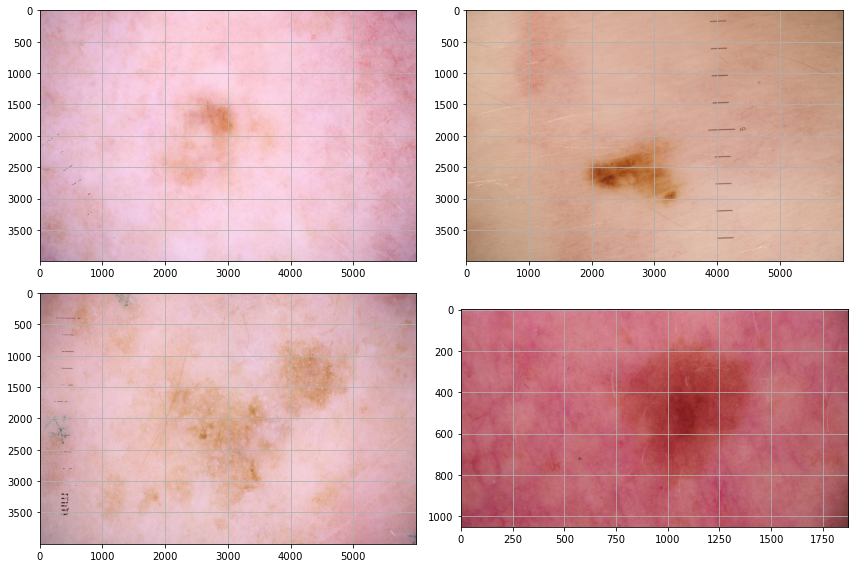

In [18]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

### Analysis of color distribution in the RGB images

Benign Cases : 

Since we have a lot of images here, hence we randomly sample only a thousand of them.

In [19]:
# Benign Cases
benign = train[train["target"] == 0] 
image_names = benign["image_name"].values
image_names = image_names + ".jpg"
benign_image_list = [np.random.choice(image_names) for i in tqdm(range(1000))]

red = []
green = [] 
blue = []

for image_name in tqdm(benign_image_list) : 
    image = cv2.imread(os.path.join(train_dir, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Channel plotting

The range of spread = 195.73


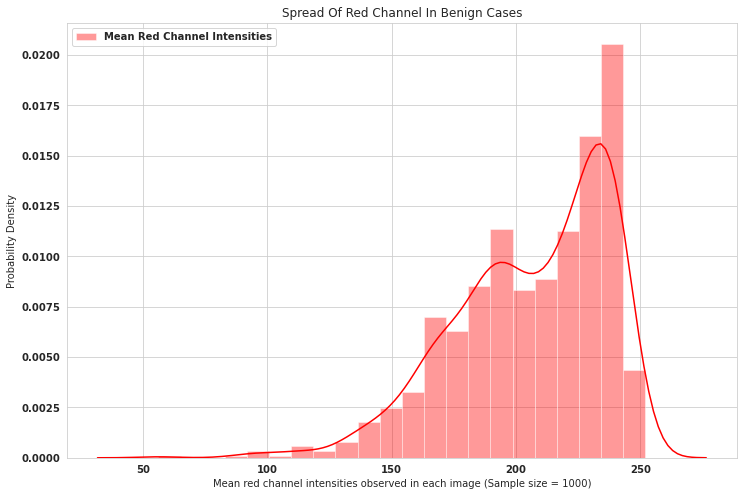

In [20]:
#red channel plot
range_of_spread = max(red) - min(red)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(red, hist = True, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig.set(xlabel = "Mean red channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density")
plt.title("Spread Of Red Channel In Benign Cases")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 206.63


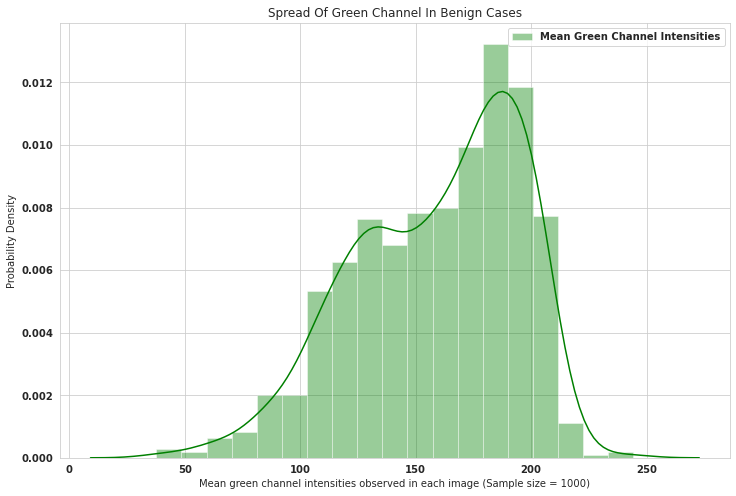

In [21]:
#green channel plot
range_of_spread = max(green) - min(green)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(green, hist = True, kde = True, label = "Mean Green Channel Intensities", color = "g")
fig.set(xlabel = "Mean green channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Green Channel In Benign Cases")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 218.35


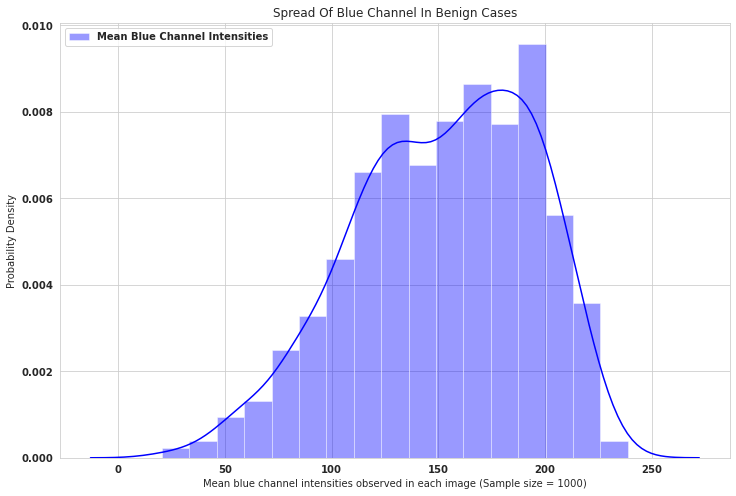

In [22]:
#Blue channel plot
range_of_spread = max(blue) - min(blue)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = True, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig.set(xlabel = "Mean blue channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Blue Channel In Benign Cases")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

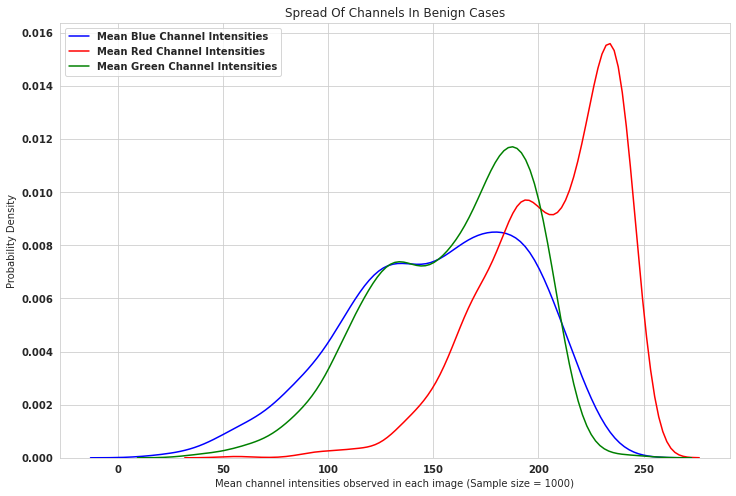

In [23]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(red, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(green, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Channels In Benign Cases")
plt.legend()

Malignant Cases 

In [24]:
# free up the memory
del red
del green
del blue

In [25]:
# Benign Cases
malignant = train[train["target"] == 1] 
image_names = malignant["image_name"].values
image_names = image_names + ".jpg"
benign_image_list = [np.random.choice(image_names) for i in tqdm(range(len(image_names)))]

red = []
green = [] 
blue = []

for image_name in tqdm(benign_image_list) : 
    image = cv2.imread(os.path.join(train_dir, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


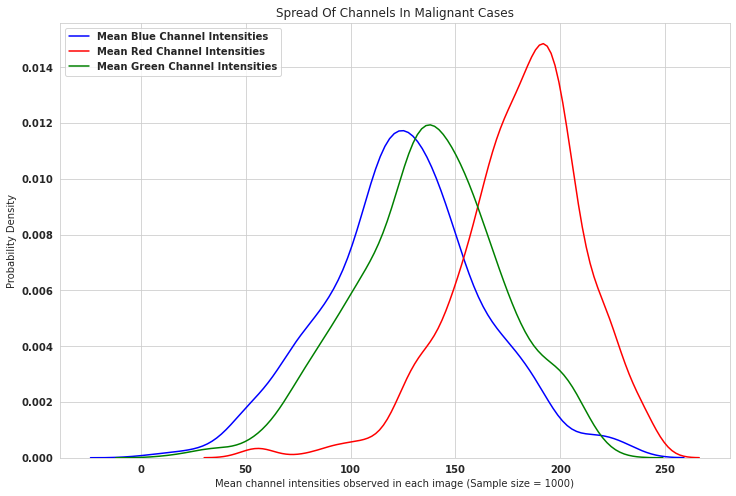

In [26]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(red, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(green, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Channels In Malignant Cases")
plt.legend()

So, we observe that in both the cases the component of red spikes the most, whereas Blue and Green are close to each other. All the channels also appears to be a bit negatively skewed. Hence, the channel distribution won't be a powerful feature to differentiate between the malignant and benign cases.